In [0]:
%pip install mlflow prophet scikit-learn pandas
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mlflow.models.signature import infer_signature 

# 1. Load Data
pdf = spark.table("agriculture.silver.crop_recommendation").toPandas()

# 2. Prepare Features
X = pdf[['nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall']]
y = pdf['crop_name']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. MLflow Tracking
mlflow.set_experiment("/Users/skmanjunath16@gmail.com/Agriculture_Experiments") 
experiment_name = "Agronomist_Viability_Model"

with mlflow.start_run(run_name=experiment_name) as run:
    # Train Model
    rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    rf.fit(X_train, y_train)
    
    # Evaluate
    predictions = rf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    print(f"Agronomist Model Accuracy: {acc:.2f}")
    
    # 4. Create the Signature (The "Contract")
    signature = infer_signature(X_train, predictions)
    
    # 5. Log & Register with Signature
    mlflow.sklearn.log_model(
        sk_model=rf, 
        name="model", 
        registered_model_name="agriculture.silver.crop_classifier", 
        signature=signature,
        input_example=X_train.head(1)
    )


print("Agronomist Model trained, signed, and registered successfully.")

Agronomist Model Accuracy: 0.99


🔗 View Logged Model at: https://dbc-7743a977-4a0c.cloud.databricks.com/ml/experiments/3138492240893527/models/m-58f6426b5657425db9b8b4ab243d86e6?o=7474657107961856
Registered model 'agriculture.silver.crop_classifier' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

🔗 Created version '3' of model 'agriculture.silver.crop_classifier': https://dbc-7743a977-4a0c.cloud.databricks.com/explore/data/models/agriculture/silver/crop_classifier/version/3?o=7474657107961856


Agronomist Model trained, signed, and registered successfully.


Generating predictions for detailed evaluation.

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        17
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        24
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        24
      grapes       1.00      1.00      1.00        19
        jute       0.91      1.00      0.95        21
      lentil       1.00      1.00      1.00        20
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00        20
      papaya       1.00      1.00      1.00        22
 pomegranate       1.00      1.00      1.00        28
        rice       1.00      0.90      0.95        20

    accuracy                           0.99       300
 

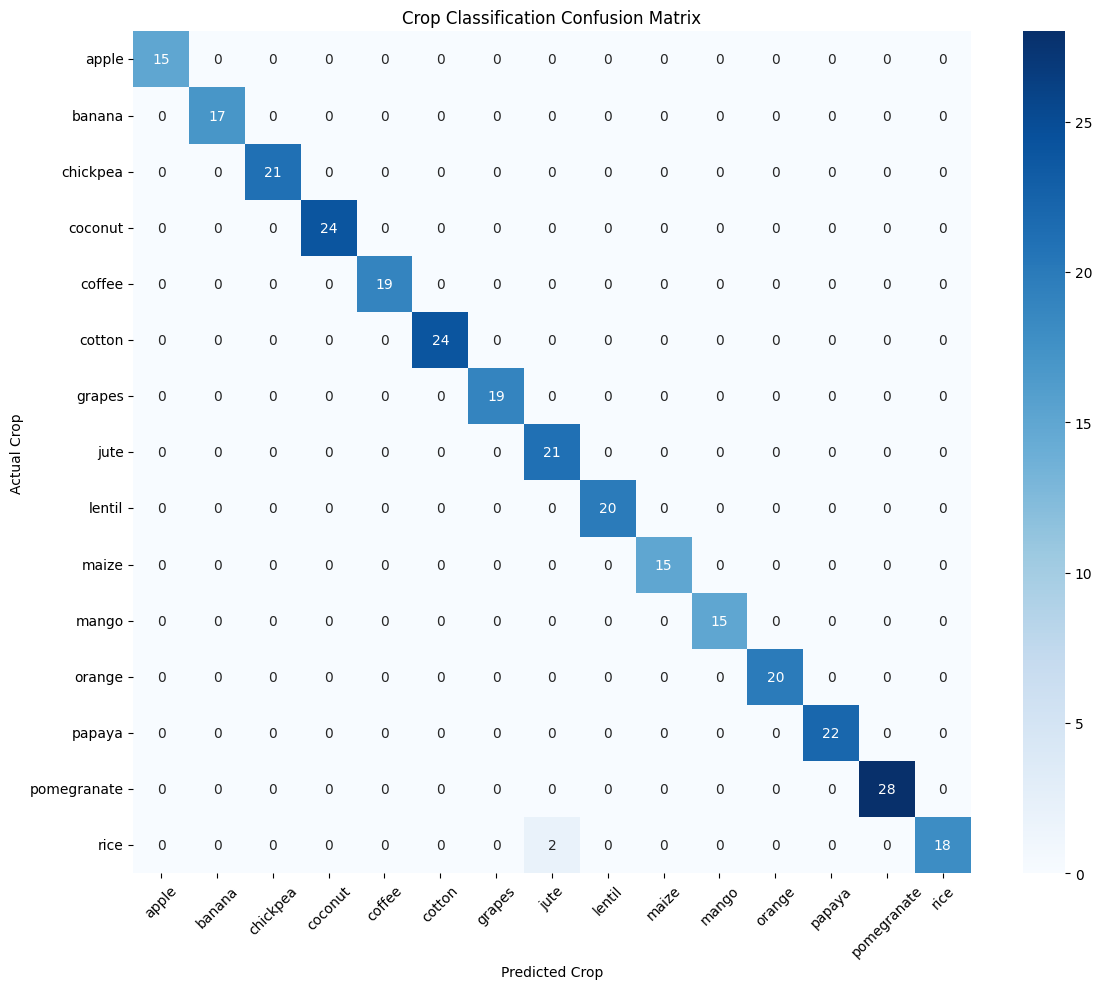


=== FEATURE IMPORTANCE ===


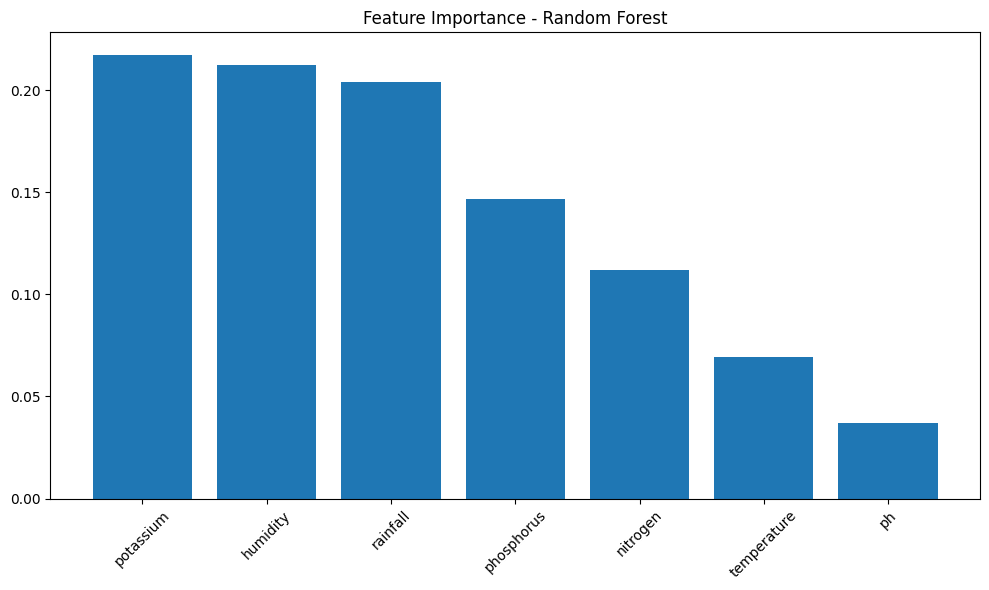

No active MLflow run found. Plots generated but not logged.


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Generate Predictions
print("Generating predictions for detailed evaluation.")
predictions = rf.predict(X_test)

# 2. Classification Report (Precision, Recall, F1-Score)
print("\n=== CLASSIFICATION REPORT ===")
report = classification_report(y_test, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(classification_report(y_test, predictions))

# 3. Confusion Matrix Visualization
print("\n=== CONFUSION MATRIX ===")
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Crop Classification Confusion Matrix')
plt.ylabel('Actual Crop')
plt.xlabel('Predicted Crop')
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot to log in MLflow
plt.savefig("/tmp/confusion_matrix.png")
plt.show()

# 4. Feature Importance Visualization
print("\n=== FEATURE IMPORTANCE ===")
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.savefig("/tmp/feature_importance.png")
plt.show()

# 5. Log Artifacts to MLflow
try:
    import mlflow
    if mlflow.active_run():
        mlflow.log_artifact("/tmp/confusion_matrix.png")
        mlflow.log_artifact("/tmp/feature_importance.png")
        print("Plots logged to MLflow successfully!")
    else:
        print("No active MLflow run found. Plots generated but not logged.")
except Exception as e:
    print(f"Skipped logging to MLflow: {e}")